### **Correlation Between Temperature(Environmental Factors) and Athlete Performance Metrics**

This analysis explores the correlation between environmental factors and athlete performance metric using the activities_cleaned dataset. The primary objective is to understand how humidity, wind speed and temperature influence running performance.

The flow is as follows;

1.   **Data Cleaning and Preprocessing** - Prepare the dataset for analysis by handling missing values, extreme outliers.
2.   **Temperature Analysis** - Explore how temperature affects running performance.
3.   **XGBoost Modelling** - Build a predictive model to evaluate how environmental factors (humidity, wind speed and temperature) impact performance together.



### Clean and Preprocess the dataset

In [1]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the dataset
# data = pd.read_csv("C:/Users/wiman/redback-fit-sports-performance/Running Analysis/activities_cleaned.csv")
data = pd.read_csv("/content/activities_cleaned.csv")
data.head()

,Activity ID,Activity Type,Begin Timestamp,End Timestamp,Max. Elevation (Raw),Min. Elevation (Raw),Elevation Gain (Raw),Elevation Loss (Raw),Average Heart Rate (bpm),Max. Heart Rate (bpm).1,Average Moving Speed,Average Speed,Max. Speed,Distance (Raw),Duration (h:m:s),Moving Duration (h:m:s),Calories,Device,Begin Latitude (Decimal Degrees Raw),Begin Longitude (Decimal Degrees Raw),End Latitude (Decimal Degrees Raw),End Longitude (Decimal Degrees Raw),Temperature (Raw),Wind Speed (Raw),Wind Direction,Humidity (Raw),Condition,Rainfall
0,2284658991,Running,4/11/2017 12:07,4/11/2017 13:06,472.6,472.6,315.0,314.0,182,113,6:47,6:47,4:55,8.66881,0:59:03,0:58:50,753,Vivoactive HR 4.0.0.0,48.019178,7.856356,48.019369,7.855831,13.9,11,S,77,fair,no
1,2284658936,Running,3/11/2017 9:47,3/11/2017 10:35,473.2,473.2,245.0,244.0,177,100,6:18,6:18,4:33,7.62835,0:48:00,0:48:02,626,Vivoactive HR 4.0.0.0,48.017859,7.881881,48.019410,7.855922,11.1,3,N,100,fair,no
2,2228102647,Running,25/10/2017 16:31,25/10/2017 17:11,278.8,278.8,208.0,272.0,179,95,5:52,5:52,4:29,6.60755,0:39:18,0:38:44,528,Vivoactive HR 4.0.0.0,48.018396,7.880602,48.019329,7.855921,20.0,6,SSW,60,fair,no
3,2104984694,Running,13/10/2017 11:53,13/10/2017 12:41,471.6,471.6,246.0,244.0,180,109,6:11,6:11,4:27,7.75709,0:48:10,0:47:57,661,Vivoactive HR 4.0.0.0,48.019194,7.856334,48.019312,7.855894,17.2,5,SSO,72,fair,no
4,2084195352,Running,2/10/2017 14:51,2/10/2017 15:38,494.6,494.6,246.0,240.0,174,110,6:01,6:01,4:19,7.81321,0:47:40,0:47:04,619,Vivoactive HR 4.0.0.0,48.019116,7.857145,48.019371,7.856066,17.8,19,SW,77,mostly cloudy,no


In [2]:
# number of rows and columns
data.shape

(155, 28)

In [3]:
# make a new copy of the dataset
new_data = data.copy()
# extract relevant features
new_data = new_data[['Elevation Gain (Raw)','Elevation Loss (Raw)','Average Heart Rate (bpm)','Average Speed','Distance (Raw)',
'Moving Duration (h:m:s)','Calories','Temperature (Raw)','Wind Speed (Raw)','Humidity (Raw)']]
# rename columns
new_data.rename(columns={'Elevation Gain (Raw)':'Elevation_Gain','Elevation Loss (Raw)':'Elevation_Loss','Average Heart Rate (bpm)':'Average_Heart_Rate','Distance (Raw)':'Distance',
'Moving Duration (h:m:s)':'Moving_Duration','Temperature (Raw)':'Temperature','Wind Speed (Raw)':'Wind_Speed','Humidity (Raw)':'Humidity'}, inplace=True)
new_data.head()

,Elevation_Gain,Elevation_Loss,Average_Heart_Rate,Average Speed,Distance,Moving_Duration,Calories,Temperature,Wind_Speed,Humidity
0,315.0,314.0,182,6:47,8.66881,0:58:50,753,13.9,11,77
1,245.0,244.0,177,6:18,7.62835,0:48:02,626,11.1,3,100
2,208.0,272.0,179,5:52,6.60755,0:38:44,528,20.0,6,60
3,246.0,244.0,180,6:11,7.75709,0:47:57,661,17.2,5,72
4,246.0,240.0,174,6:01,7.81321,0:47:04,619,17.8,19,77


In [4]:
# convert time format from h:m:s to s(seconds)
new_data['Moving_Duration_s'] = pd.to_timedelta(new_data['Moving_Duration']).dt.total_seconds()
# drop the previous column and replace the new one
new_data.drop(columns='Moving_Duration', inplace=True)
# convert calories to float datatype
new_data['Calories'] = pd.to_numeric(new_data['Calories'], errors='coerce')

In [5]:
# convert average speed column to kmh
# assuming that the pace is given in the average speed column
# convert pace to speed
new_data[['min','sec']] = new_data['Average Speed'].str.split(':',expand=True).astype(float)
new_data['pace'] = new_data['min'] + new_data['sec'] /60
new_data['Average_Speed_kmh'] = 60/new_data['pace']
# clean up the dataset
new_data.drop(columns=['Average Speed','min','sec','pace'], inplace=True)

In [6]:
new_data.head()

,Elevation_Gain,Elevation_Loss,Average_Heart_Rate,Distance,Calories,Temperature,Wind_Speed,Humidity,Moving_Duration_s,Average_Speed_kmh
0,315.0,314.0,182,8.66881,753.0,13.9,11,77,3530.0,8.845209
1,245.0,244.0,177,7.62835,626.0,11.1,3,100,2882.0,9.523810
2,208.0,272.0,179,6.60755,528.0,20.0,6,60,2324.0,10.227273
3,246.0,244.0,180,7.75709,661.0,17.2,5,72,2877.0,9.703504
4,246.0,240.0,174,7.81321,619.0,17.8,19,77,2824.0,9.972299


In [7]:
new_data.dtypes # all the features are numerical

,0
Elevation_Gain,float64
Elevation_Loss,float64
Average_Heart_Rate,int64
Distance,float64
Calories,float64
Temperature,float64
Wind_Speed,int64
Humidity,int64
Moving_Duration_s,float64
Average_Speed_kmh,float64


In [8]:
# check for null values
new_data.isnull().sum()

,0
Elevation_Gain,0
Elevation_Loss,0
Average_Heart_Rate,0
Distance,0
Calories,4
Temperature,0
Wind_Speed,0
Humidity,0
Moving_Duration_s,0
Average_Speed_kmh,0


There are four missing values are in the "Calories" column.

In [9]:
# fill null values in the 'calories' column by its mean or median based on the skewness
# Calculate the skewness
skewness = new_data['Calories'].skew()
# if the absolute value is less than 0.5
if np.abs(skewness) < 0.5:
    # replace the null values by mean
    value = new_data['Calories'].mean()
else:
    # o/w replace by median
    value = new_data['Calories'].median()

new_data["Calories"].fillna(value)

,Calories
0,753.0
1,626.0
2,528.0
3,661.0
4,619.0
...,...
150,308.0
151,386.0
152,287.0
153,351.0


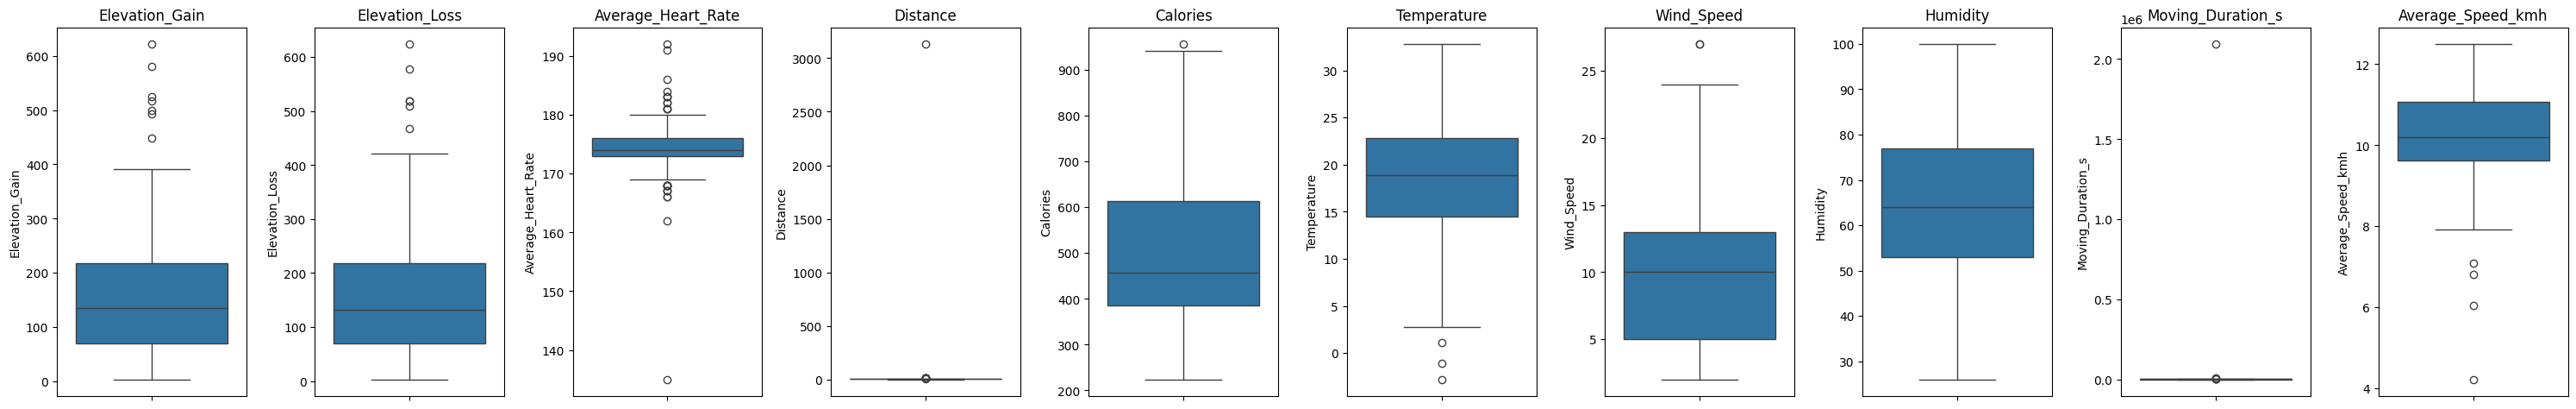

In [10]:
# check for the outliers
# extract all the numeric data columns
numeric_col = new_data.columns
# create box plots for each column
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_col), figsize=(3*len(numeric_col),5))
for i,col in enumerate(numeric_col):
    sns.boxplot(y=new_data[col],ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

There are some unusual values in the dataset particularly in Distance and Moving Duration features, which are considered as extreme outliers. To address this, the Inter-Quartile Range (IQR) will apply to remove these extreme outliers. Addition to that, most of the features in the dataset show skewed distributions, meaning they are not normally distributed.

In [11]:
# remove extreme outliers from following features
# use the multiplier as 3 instead of 1.5 to remove extreme outliers
columns = new_data.columns
# calculate IQR for both features using for loop
for col in columns:
    Q1 = new_data[col].quantile(0.25)
    Q3 = new_data[col].quantile(0.75)
    IQR = Q3-Q1
    lower_boundry = Q1 - 3 * IQR
    upper_boundry = Q3 + 3 * IQR
    # remain values, which is higher than the lower boundary and lower than the upper boundary
    new_data = new_data[(new_data[col] >= lower_boundry) & (new_data[col] <= upper_boundry)]

In [12]:
new_data.shape

(142, 10)

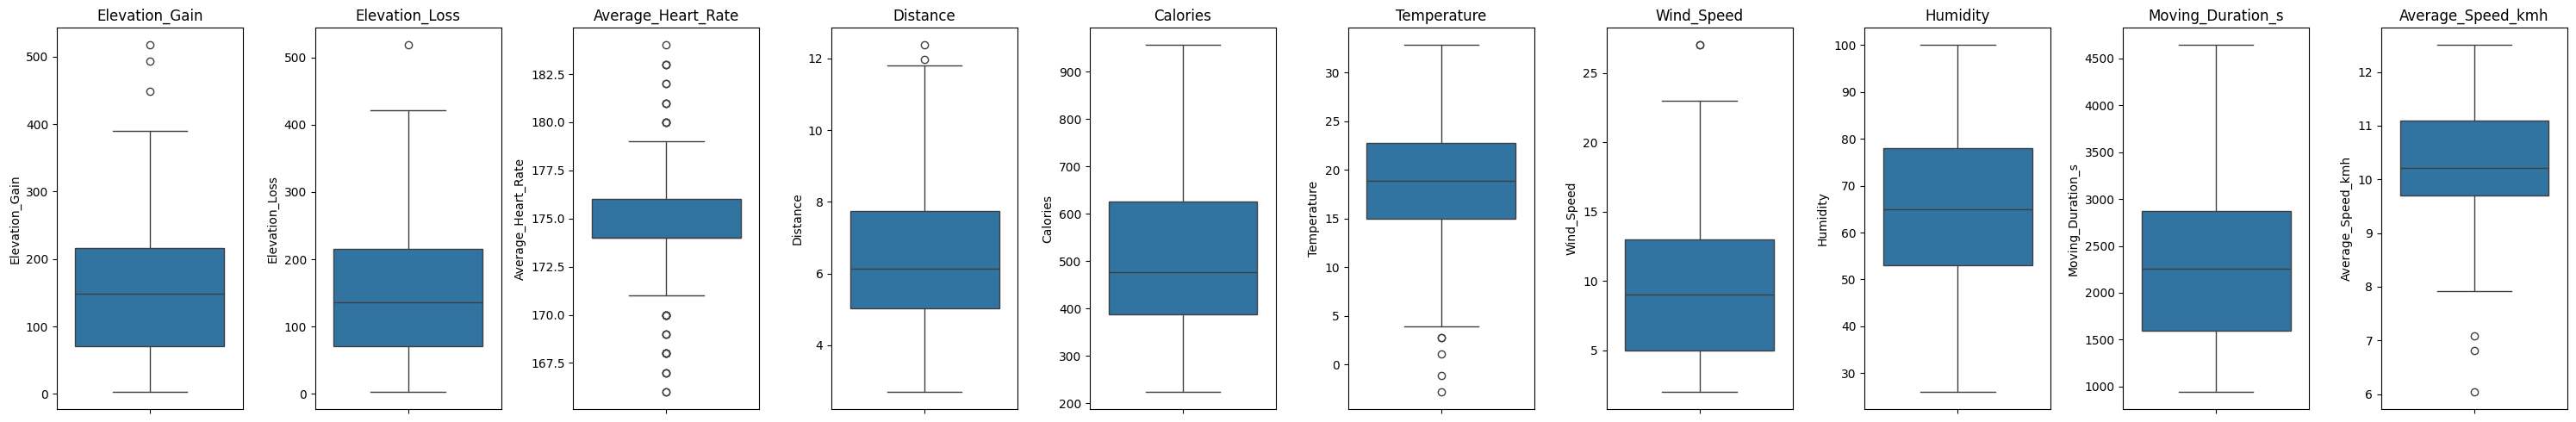

In [12]:
# again, check for the outliers
numeric_col = new_data.columns
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_col), figsize=(3*len(numeric_col),5))
for i,col in enumerate(numeric_col):
    sns.boxplot(y=new_data[col],ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

In [13]:
# standardised the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_new_data = scaler.fit_transform(new_data)

### Correlate Temperature and Athlete Perfromance Metrics

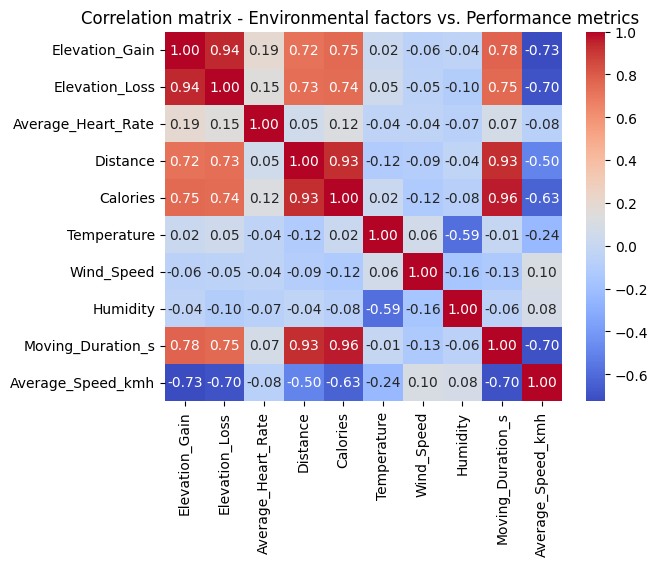

In [14]:
# convert back to dataframe
scaled_data = pd.DataFrame(scaled_new_data, columns=new_data.columns)

# find the correlation using heatmap
# used spearman correlation due to the skewed data and outliers
corr_matrix = scaled_data.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix - Environmental factors vs. Performance metrics ')
plt.show()

The correlation heatmap shows that temperature has a weak association with performance metrics. For example, average speed indicates -0.24 correlation with temperature, indicating a very weak negative relationship as temperature increases, average speed tends to decreases slightly. However, the effect is not strong.  

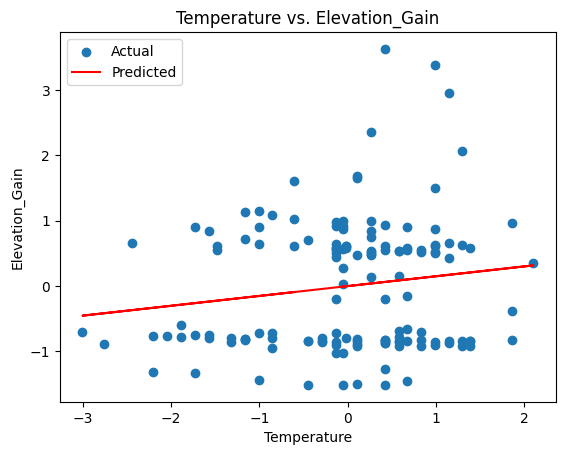

R2 score for Temperature vs Elevation_Gain :0.023



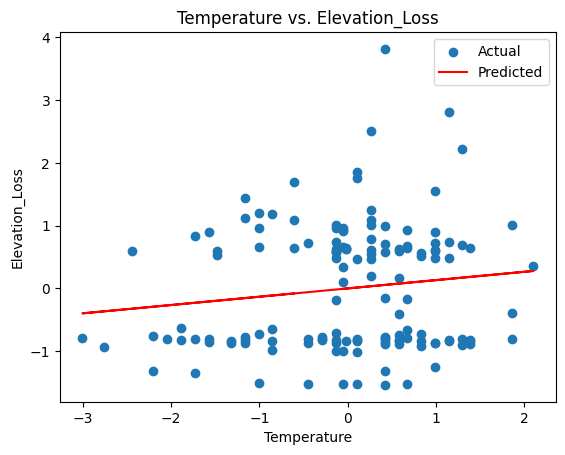

R2 score for Temperature vs Elevation_Loss :0.017



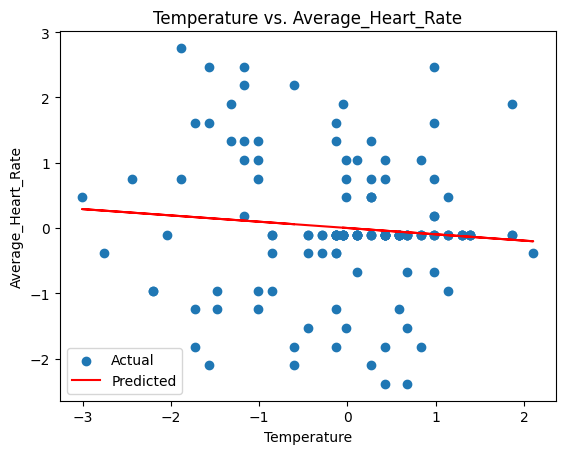

R2 score for Temperature vs Average_Heart_Rate :0.009



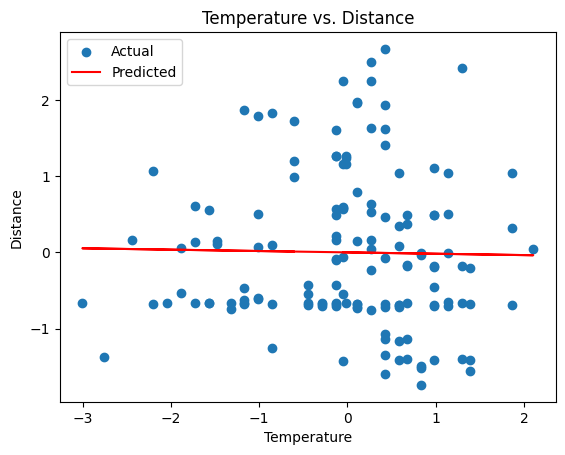

R2 score for Temperature vs Distance :0.000



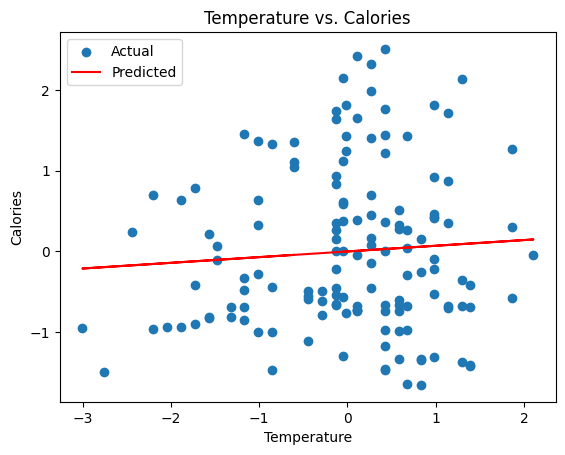

R2 score for Temperature vs Calories :0.005



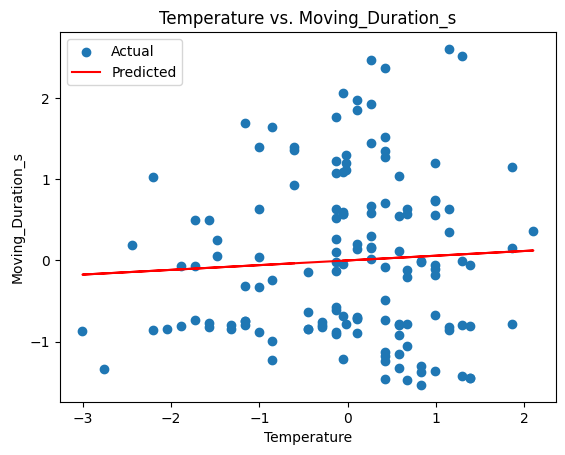

R2 score for Temperature vs Moving_Duration_s :0.003



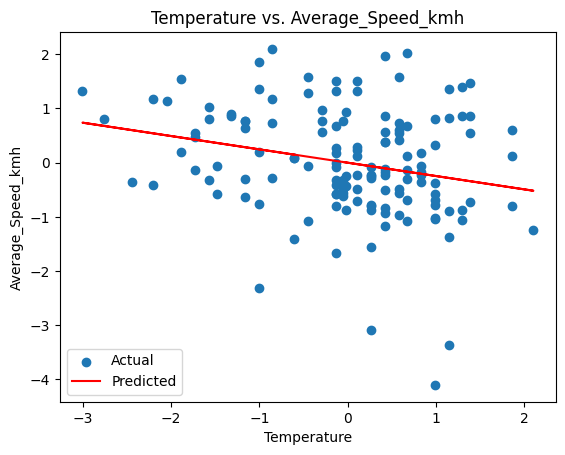

R2 score for Temperature vs Average_Speed_kmh :0.060



In [15]:
# Relationship between temperature and average heart rate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# performance metrics
per_met = ['Elevation_Gain','Elevation_Loss','Average_Heart_Rate','Distance','Calories','Moving_Duration_s','Average_Speed_kmh']

for performance in per_met:
  # fit linear regression
  model = LinearRegression()
  model.fit(scaled_data[['Temperature']],scaled_data[performance])
  # predicted values
  y_pred = model.predict(scaled_data[['Temperature']])
  # calculate the r2 score
  r2 = r2_score(scaled_data[performance],y_pred)
  # plot
  plt.scatter(scaled_data[['Temperature']],scaled_data[performance], label='Actual')
  plt.plot(scaled_data[['Temperature']],y_pred, color='red', label='Predicted')
  plt.xlabel('Temperature')
  plt.ylabel(performance)
  plt.title(f'Temperature vs. {performance}')
  plt.legend()
  plt.show()

  print(f"R2 score for Temperature vs {performance} :{r2:.3f}\n")

According to the above plots,

The relationship between temperature and the performance metrics is very weak according to R2 scores, which explain less than 10% of the variability. For example,
1.   The average heart rate shows a negative relationship with temperature, showing tendency to decrease as temperature arise. However, there is no clear linear relationship between variables. Temperature explains only 0.9% of the variance in average heart rate.
2.   There is a very low positive correlation between the temperature and elevation loss, indicating the elevation loss decreases slightly as temperature gets warmer. However, temperature explains only 1.7% of variance in elevation loss.
3.   And also, average speed tends to decrease as temperature increases.

Overall, these reuslts indicate that temperature has a minimal impact on the performance metrics.  

Since temperature and humidity are negatively correlated, an interaction term (temperature*humidity) was created to explore their cobined effect on performance metrics.

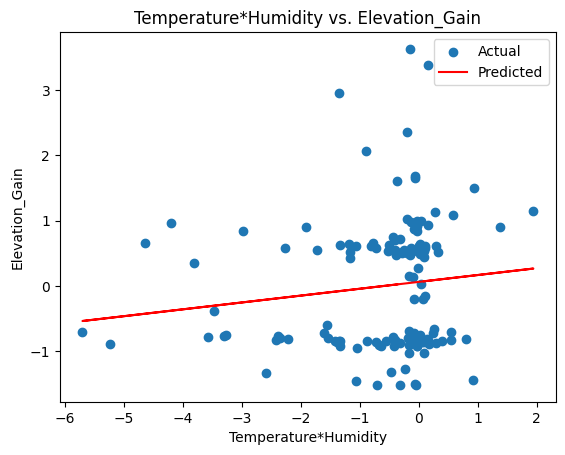

R2 score for Temperature_Humidity vs Elevation_Gain :0.016



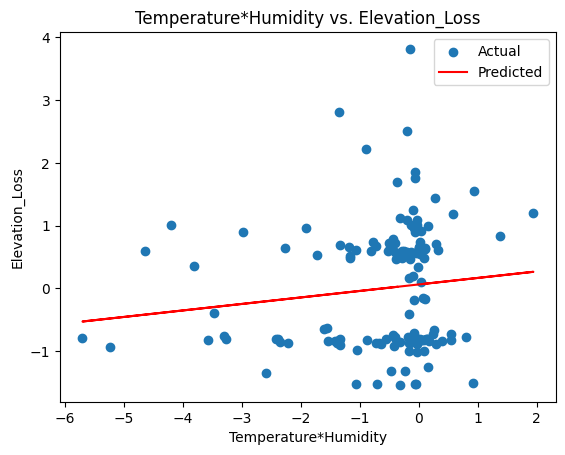

R2 score for Temperature_Humidity vs Elevation_Loss :0.015



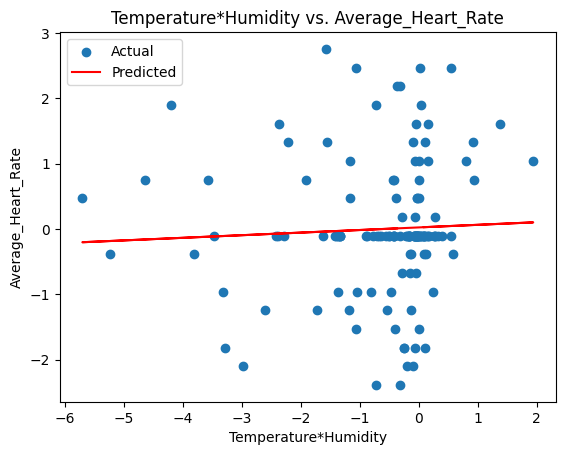

R2 score for Temperature_Humidity vs Average_Heart_Rate :0.002



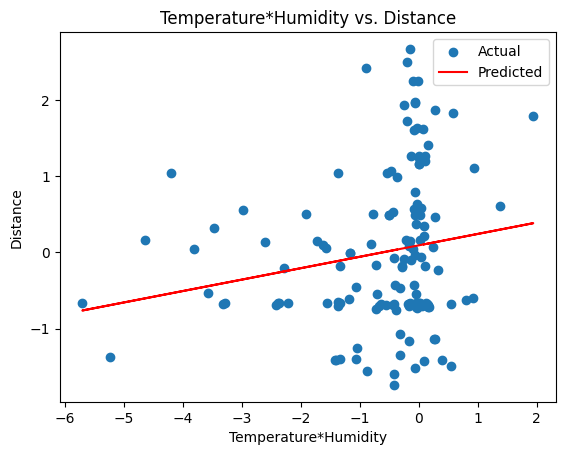

R2 score for Temperature_Humidity vs Distance :0.032



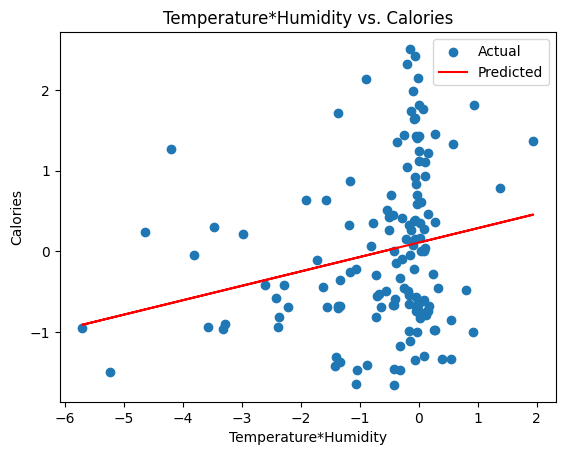

R2 score for Temperature_Humidity vs Calories :0.046



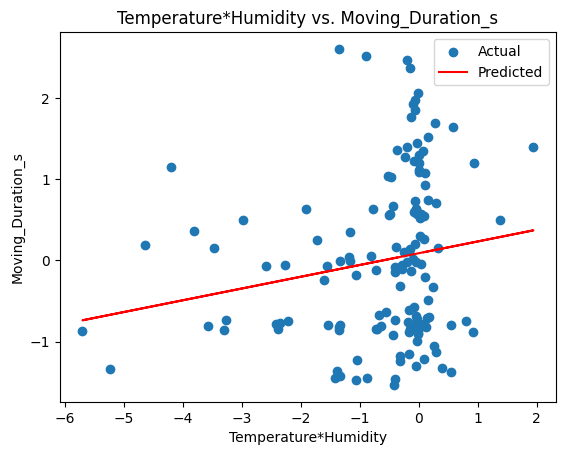

R2 score for Temperature_Humidity vs Moving_Duration_s :0.030



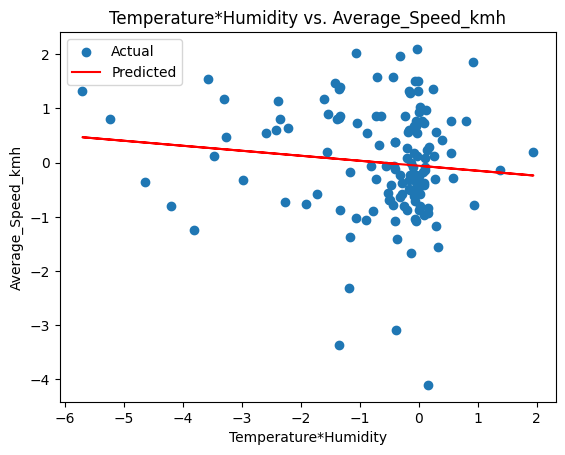

R2 score for Temperature_Humidity vs Average_Speed_kmh :0.012



In [16]:
# interaction term
scaled_data['Temperature_Humidity'] = scaled_data['Temperature'] * scaled_data['Humidity']
# plot simple linear regression models
for performance in per_met:
  # fit linear regression
  model = LinearRegression()
  model.fit(scaled_data[['Temperature_Humidity']],scaled_data[performance])
  # predicted values
  y_pred = model.predict(scaled_data[['Temperature_Humidity']])
  # calculate the r2 score
  r2 = r2_score(scaled_data[performance],y_pred)
  # plot
  plt.scatter(scaled_data[['Temperature_Humidity']],scaled_data[performance], label='Actual')
  plt.plot(scaled_data[['Temperature_Humidity']],y_pred, color='red', label='Predicted')
  plt.xlabel('Temperature*Humidity')
  plt.ylabel(performance)
  plt.title(f'Temperature*Humidity vs. {performance}')
  plt.legend()
  plt.show()

  print(f"R2 score for Temperature_Humidity vs {performance} :{r2:.3f}\n")

Still the R2 score for (temperature*humidity) is lower than 10%, indicating that even when considering their combined effect, temperature and humidity explain a very small proportion of the variablity in the performance metrics.  

### **XGBoost Regression Model**

The XGBoost Regression Model performs to identify any non-linear relationship between environmental factors and athlete performance metrics.

In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

# environmental factors
x = new_data[['Temperature', 'Wind_Speed', 'Humidity']]
# athlete performance
Y = new_data[['Elevation_Loss','Elevation_Gain','Average_Heart_Rate','Distance','Calories','Moving_Duration_s','Average_Speed_kmh']]

In [18]:
# split the data
# 70% of the data is used to train the model
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.3, random_state=42)

# tune the parameters on 'average heart rate'
param_grid ={
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.01, 0.1],
    'max_depth': [3, 4, 5]
}

grid = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror',random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=5, # 5-fold cross valiadation
    n_jobs=-1
)

grid.fit(x_train, y_train['Average_Heart_Rate'])

# best parameters
print(f"Best parameters: " , grid.best_params_)


Best parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [20]:
# XGBoost model that predicts a single output from input features
base_model =xgb.XGBRegressor(
    objective='reg:squarederror',
    #n_estimator =100,
    learning_rate = 0.01,
    max_depth = 3,
    random_state=42)
# use MultiOutputRegressor to predict all the outputs at once
model = MultiOutputRegressor(base_model)
# fit the model for each performance metric
model.fit(x_train,y_train)

# make predictions
y_pred = model.predict(x_test)

In [22]:
result = {}

for i,col in enumerate(Y.columns):
  # mse - average squared difference between predicted and actual values
  mse = round(mean_squared_error(y_test.iloc[:,i], y_pred[:,i]),3)
  # r2 score
  r2 = round(r2_score(y_test.iloc[:,i], y_pred[:,i]),3)
  result[col] = {"MSE":mse, "R2": r2}

results_df=pd.DataFrame(result).T
print(results_df)

# feature importance
importance = pd.DataFrame(columns=x.columns, index=Y.columns)
for i, col in enumerate(Y.columns):
  importance.loc[col]=model.estimators_[i].feature_importances_

importance = importance.round(3)
print("\nFeature Importance Metrics")
print(importance)

                           MSE     R2
Elevation_Loss       10069.682 -0.164
Elevation_Gain       10949.690 -0.223
Average_Heart_Rate      14.216 -0.375
Distance                 4.073  0.057
Calories             25828.373  0.011
Moving_Duration_s   802042.468 -0.014
Average_Speed_kmh        1.284 -0.039

Feature Importance Metrics
                   Temperature Wind_Speed  Humidity
Elevation_Loss        0.237472   0.408173  0.354355
Elevation_Gain        0.202229   0.426384  0.371387
Average_Heart_Rate    0.544667   0.170205  0.285128
Distance              0.232739   0.414916  0.352344
Calories              0.269787   0.364272   0.36594
Moving_Duration_s     0.232566   0.369986  0.397447
Average_Speed_kmh     0.495297   0.233359  0.271344


According to the results, the low or negative R2 scores are expected because of the non-linear nature of the dataset and the weak relationship between environmental factors and performance metrics. This suggests that the environmnetal factors have limited influence on the athlete's performance.

The feature importance results indicate that all three environmental factors contribute similarly to athlete performance.

### **Summary of Findings**

*   **Dataset** - activities_cleaned.csv from the running activities.
*   **Method** - Performed the pearson correlation analysis to find and evaluate the linear relationship between environmnetal factors and athlete performance metrics.
*   **Data Preprocessing** - Removed extreme unusual entries from the dataset. Resulting in 142 entries. Focused on a subset of ten relevant features out of 28.
*   **Results** - Observed very weak relationship between the environmental factors and selected athlete performance metrics.

    XGBoost Regression model is performed to explore the non-linear relationship between the environmnetal factors and the athlete performance metrics. The model showed low and negative R2 scores, indicating the environmental factors can't explain much variance in athlete's performance.



